In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import io
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

pd.options.display.float_format = '{:.3f}'.format

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,nan,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [5]:
df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


In [6]:
#create lists of continuous and categorical variables
num_col = df.select_dtypes(['int64', 'float64']).columns
non_num = df.select_dtypes(['object']).columns

In [7]:
num_col

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')

In [8]:
non_num

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

In [9]:
#look for attributes with missing data
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995
miscfeature,1406,0.963
alley,1369,0.938
fence,1179,0.808
fireplacequ,690,0.473
lotfrontage,259,0.177
garagecond,81,0.055
garagetype,81,0.055
garageyrblt,81,0.055
garagefinish,81,0.055


In [10]:
#for numeric variables, calculate the correlation to sales price for each
np.abs(df[num_col].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice       1.000
overallqual     0.791
grlivarea       0.709
garagecars      0.640
garagearea      0.623
totalbsmtsf     0.614
firstflrsf      0.606
fullbath        0.561
totrmsabvgrd    0.534
yearbuilt       0.523
yearremodadd    0.507
garageyrblt     0.486
masvnrarea      0.477
fireplaces      0.467
bsmtfinsf1      0.386
lotfrontage     0.352
wooddecksf      0.324
secondflrsf     0.319
openporchsf     0.316
halfbath        0.284
lotarea         0.264
bsmtfullbath    0.227
bsmtunfsf       0.214
bedroomabvgr    0.168
kitchenabvgr    0.136
enclosedporch   0.129
screenporch     0.111
poolarea        0.092
mssubclass      0.084
overallcond     0.078
mosold          0.046
threessnporch   0.045
yrsold          0.029
lowqualfinsf    0.026
miscval         0.021
bsmthalfbath    0.017
bsmtfinsf2      0.011
Name: saleprice, dtype: float64

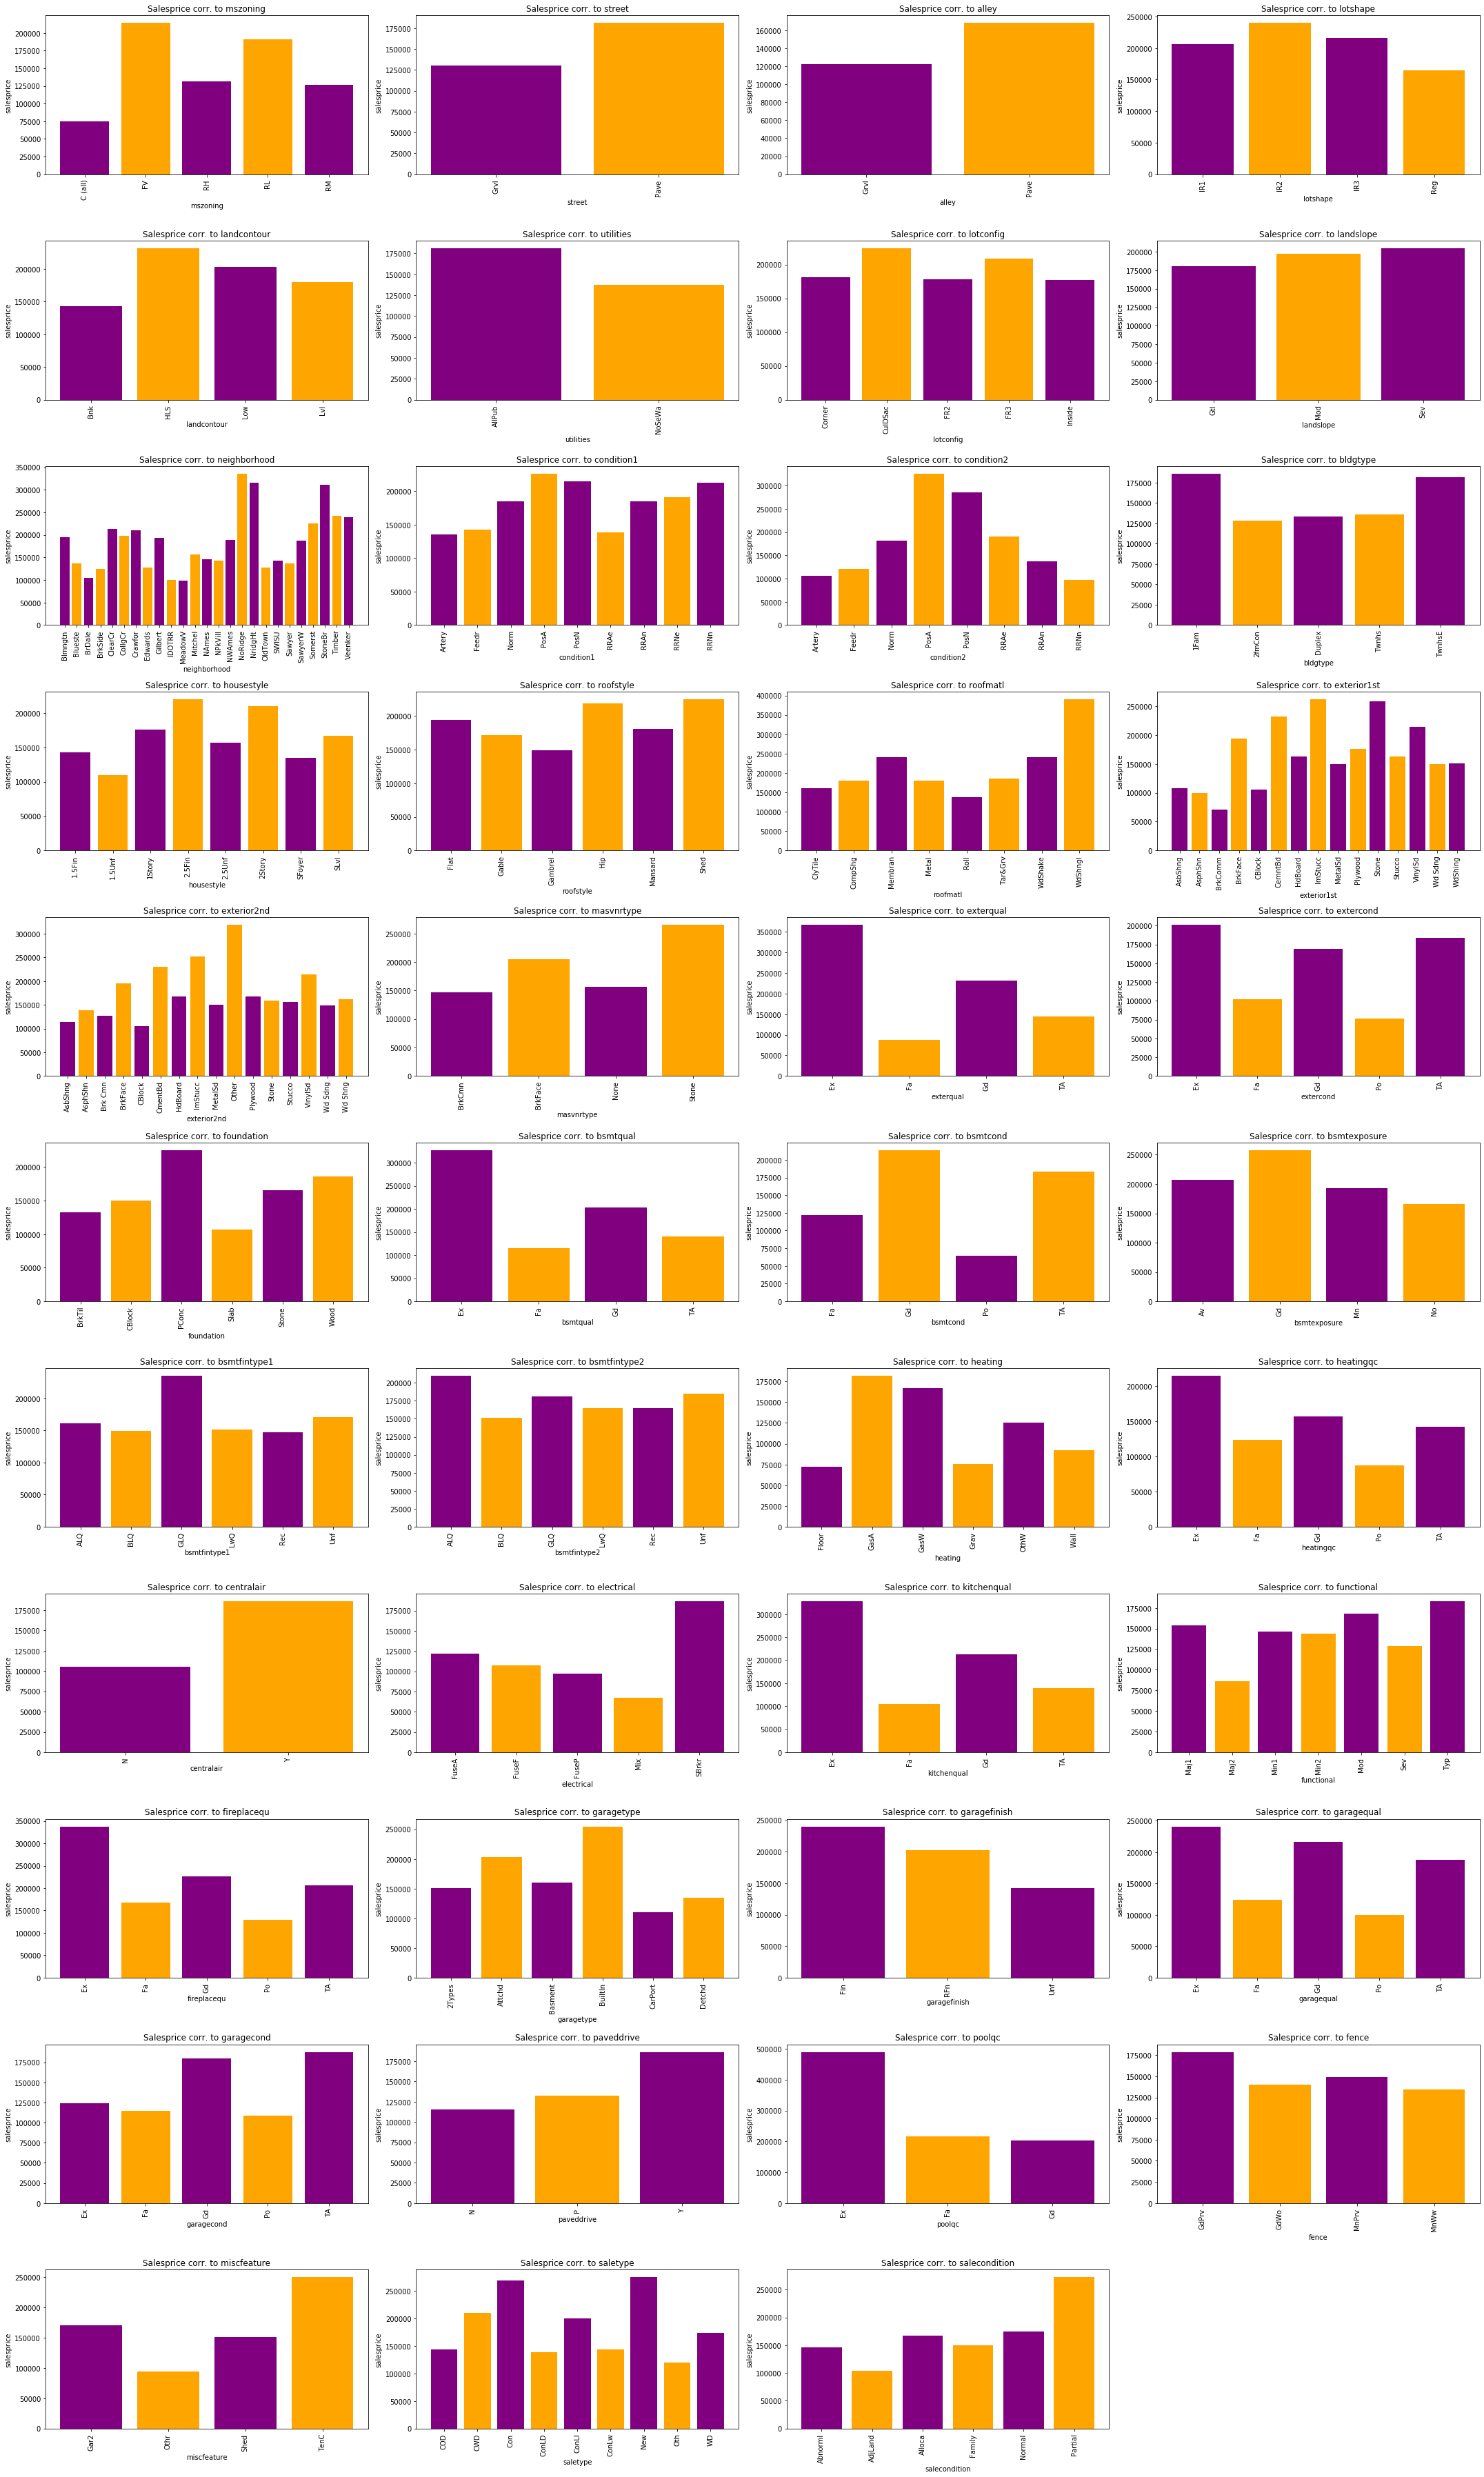

In [11]:
#for non-numeric variables plot their relation to sales price to look for correlations
plt.figure(figsize=(30,50))

for index, column in enumerate(non_num):
    plt.subplot(11,4,index+1)
    plt.bar(df.groupby(column)["saleprice"].mean().index, df.groupby(column)["saleprice"].mean(),
           color=("purple","orange"))
    plt.title("Salesprice corr. to {}".format(column))
    plt.ylabel("salesprice")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

NOTE: After looking at all numeric and non-numeric values, we conclude that the attributes listed above that have missing values are NOT the attributes with the highest correlation to price, so they can be left alone for now.

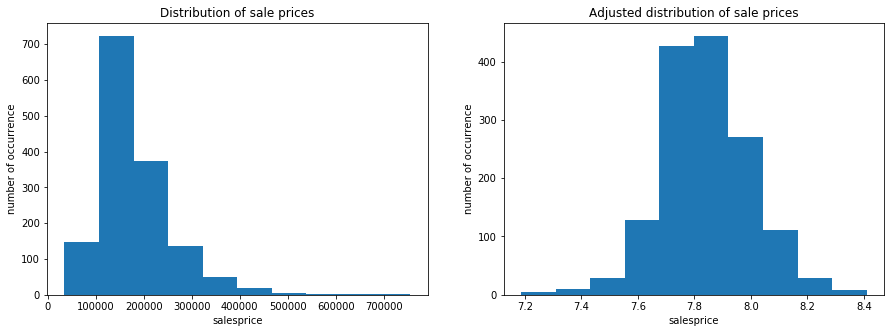

In [12]:
#how are sales prices distributed?
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(df.saleprice)
plt.title("Distribution of sale prices")
plt.xlabel("salesprice")
plt.ylabel("number of occurrence")

#Use box cox transformation to shape sales price data into a more normal distribution
#Use this new variable in the regression model
df['adj_saleprice'],_ = boxcox(df['saleprice'])

plt.subplot(1,2,2)
plt.hist(df.adj_saleprice)
plt.title("Adjusted distribution of sale prices")
plt.xlabel("salesprice")
plt.ylabel("number of occurrence")
plt.show()

Text(0.5, 1.0, 'Distribution of general living area')

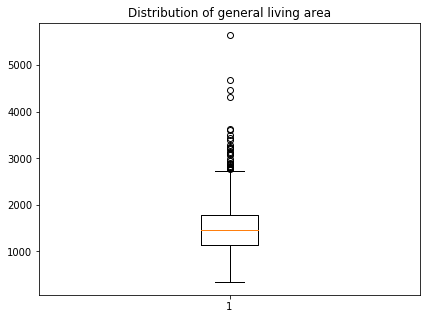

In [13]:
#look for outliers in general living area
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.boxplot(df.grlivarea)
plt.title("Distribution of general living area")

In [14]:
#drop the 2 extreme outliers in general living area
df = df.drop(df[(df['grlivarea']>4000) & (df['saleprice']<300000)].index)

#transform the distribution for general living area
df['adj_livarea'],_ = boxcox(df['grlivarea'])

Text(0.5, 1.0, 'Distribution of adjusted general living area')

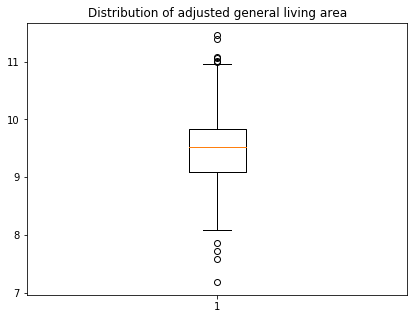

In [15]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.boxplot(df.adj_livarea)
plt.title("Distribution of adjusted general living area")

In [16]:
#add features to improve the pricing model

#create dummies for the zoning variable
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)

#create variable that includes total number of baths
df['total_bath'] = df['fullbath']+df['halfbath']+df['bsmtfullbath']+df['bsmthalfbath']

#variable that combines all the outdoor square footage
df['outdoor'] = df['openporchsf']*df['lotarea']*df['wooddecksf']

#variable that gets the total square footage of each house
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

In [17]:
#create feature that looks at years built and remodelled for each house and judge new feature correlation
df['yrbuilt_yrremodel'] = df['yearbuilt'] * df['yearremodadd']

print('Corr. year built to salesprice = {:.3f}'.format(df['yearbuilt'].corr(df['saleprice'])))
print('Corr. year remoddled to salesprice = {:.3f}'.format(df['yearremodadd'].corr(df['saleprice'])))
print('Corr. feature of both years to salesprice = {:.3f}'.format(df['yrbuilt_yrremodel'].corr(df['saleprice'])))

Corr. year built to salesprice = 0.524
Corr. year remoddled to salesprice = 0.508
Corr. feature of both years to salesprice = 0.578


# OLS Regression

In [18]:
# Y is the target variable, using the box cox adjusted salesprice
Y = np.log1p(df['adj_saleprice'])
# X is the feature set
X = df[['overallqual', 'adj_livarea', 'garagecars', 'totalsf', 'mszoning_FV', 'mszoning_RL',
                     'total_bath', 'yrbuilt_yrremodel']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1166
The number of observations in test set is 292


In [19]:
#Plot predictions vs true saleprice to see hwo good the model is doing generall
lrm = LinearRegression()
lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.8682054396979771
-----Test set statistics-----
R-squared of the model in test set is: 0.8424868884857795
Mean absolute error of the prediction is: 0.00509585793474273
Mean squared error of the prediction is: 4.764690396758467e-05
Root mean squared error of the prediction is: 0.006902673682536693
Mean absolute percentage error of the prediction is: 0.23444021580334212


# Lasso Regression

In [20]:
# Y is the target variable
np.log1p(df['adj_saleprice'])

# X is the feature set
X = df[['overallqual', 'adj_livarea', 'garagecars', 'totalsf', 'mszoning_FV', 'mszoning_RL',
                     'total_bath', 'yearremodadd']]


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-20,20,1)]

In [21]:
lasso_cv = LassoCV(alphas=alphas, cv=10)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-17
R-squared of the model in training set is: 0.8702661085687204
-----Test set statistics-----
R-squared of the model in test set is: 0.842671672940807
Mean absolute error of the prediction is: 0.005083997931644085
Mean squared error of the prediction is: 4.759100762283746e-05
Root mean squared error of the prediction is: 0.006898623603505083
Mean absolute percentage error of the prediction is: 0.23390693599776563


# Ridge Regression

In [22]:
# Ridge Regression
# Y is the target variable
Y = np.log1p(df['adj_saleprice'])

# X is the feature set
X = df[['overallqual', 'adj_livarea', 'garagecars', 'totalsf', 'mszoning_FV', 'mszoning_RL',
                     'total_bath', 'yearremodadd']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-20,20,1)]

In [23]:
# Ridge Regression

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridge_cv = RidgeCV(alphas=alphas, cv=10)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in training set is: 0.8702606023789518
-----Test set statistics-----
R-squared of the model in test set is: 0.8428171427593965
Mean absolute error of the prediction is: 0.005081540235310557
Mean squared error of the prediction is: 4.7547003752874656e-05
Root mean squared error of the prediction is: 0.0068954335435036035
Mean absolute percentage error of the prediction is: 0.23379300267192038


# ElasticNet Regression

In [24]:
# Y is the target variable
Y = np.log1p(df['adj_saleprice'])

# X is the feature set
X = df[['overallqual', 'adj_livarea', 'garagecars', 'totalsf', 'mszoning_FV', 'mszoning_RL',
                     'total_bath', 'yearremodadd']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
l1 = [.1, .5, .7, .9, .95, .99, 1]

In [25]:
# ElasticNet Regression

elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1) 
elastic_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elastic_cv.predict(X_train)
y_preds_test = elastic_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elastic_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elastic_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8702658704524169
-----Test set statistics-----
R-squared of the model on the test set is: 0.8427039276567553
Mean absolute error of the prediction is: 0.005083241017139048
Mean squared error of the prediction is: 4.758125073759462e-05
Root mean squared error of the prediction is: 0.006897916405523817
Mean absolute percentage error of the prediction is: 0.23387204577334408


# Results

The Ridge Model was slighly more accurate in minimizing the absolute percentage error and had the highest R-squared result for the test data. Overall, this model seems to provide the best predictions.

# External Factors affecting Price

Some of the main factors not included in our model that affect home price are:

1. Overall performance of the local market, including the number of total homes for sale at a given time period. When the supply of homes is high relative to demand, we call this a buyer's market. By contrast, in a sellar's market there is high demand for a smaller number of homes (relative to the population of buyers).  

2. Economic indicators such as employment rates, wage growth, and consumer confidence. If the ecnomomy seems to be doing well, buyers are more likely to drive up demand.

3. Interest rates can also influence demand. When interest rates are low, more potential buyers can afford homes, and buyers may shop for higher priced homes.

Since historical mortgage rate data is easy to obtain, let's upload these data and see if this new information helps our model.

In [26]:
#determine years of house prices in the dataset
df['yrsold'].unique()

array([2008, 2007, 2006, 2009, 2010])

In [27]:
#read in new data from a spreadsheet I created tracking 3 types of interest rates by month and year
url = 'https://raw.githubusercontent.com/colettegabriel/data_science/master/mort_interest_rates.csv'
data_file = requests.get(url).content

interest_df = pd.read_csv(io.StringIO(data_file.decode('ISO-8859-1')))
pd.options.mode.chained_assignment = None

In [28]:
interest_df.head()

,yrsold,mosold,30_year_FRM,15_year_FRM,1_year_ARM
0,2006,1,6.280,5.860,5.380
1,2006,2,6.400,6.020,5.470
2,2006,3,6.470,6.120,5.650
3,2006,4,6.630,6.280,5.820
4,2006,5,6.750,6.370,5.920


In [29]:
#merge new data onto existing df
new_df = pd.merge(df, interest_df, on=['yrsold', 'mosold'])

In [30]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1457
Data columns (total 94 columns):
id                   1458 non-null int64
mssubclass           1458 non-null int64
mszoning             1458 non-null object
lotfrontage          1199 non-null float64
lotarea              1458 non-null int64
street               1458 non-null object
alley                91 non-null object
lotshape             1458 non-null object
landcontour          1458 non-null object
utilities            1458 non-null object
lotconfig            1458 non-null object
landslope            1458 non-null object
neighborhood         1458 non-null object
condition1           1458 non-null object
condition2           1458 non-null object
bldgtype             1458 non-null object
housestyle           1458 non-null object
overallqual          1458 non-null int64
overallcond          1458 non-null int64
yearbuilt            1458 non-null int64
yearremodadd         1458 non-null int64
roofstyle          

In [31]:
#determine which interst rate features has best correlation
new_df['all_rates'] = new_df['30_year_FRM'] * new_df['15_year_FRM'] * new_df['1_year_ARM']

print('Corr. 30yr fixed rate to salesprice = {:.3f}'.format(new_df['30_year_FRM'].corr(new_df['saleprice'])))
print('Corr. 15yr fixed rate to salesprice = {:.3f}'.format(new_df['15_year_FRM'].corr(new_df['saleprice'])))
print('Corr. 1yr ARM to salesprice = {:.3f}'.format(new_df['1_year_ARM'].corr(new_df['saleprice'])))

print('Corr. feature of all mortage rate types to salesprice = {:.3f}'
      .format(new_df['all_rates'].corr(new_df['saleprice'])))

Corr. 30yr fixed rate to salesprice = 0.026
Corr. 15yr fixed rate to salesprice = 0.028
Corr. 1yr ARM to salesprice = 0.026
Corr. feature of all mortage rate types to salesprice = 0.026


In [32]:
# Since Ridge Regression was the best overall model, we run it again with 
#the "new_df" that incorporates interest rates.
# Y is the target variable
Y = np.log1p(new_df['adj_saleprice'])

# X is the feature set
#based on calculations above, add in 15_year_FRM as the interst rate most correlated to saleprice
X = new_df[['overallqual', 'adj_livarea', 'garagecars', 'totalsf', 'mszoning_FV', 'mszoning_RL',
                     'total_bath', 'yearremodadd', '15_year_FRM']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

alphas = [np.power(10.0,p) for p in np.arange(-20,20,1)]

In [33]:
# Ridge Regression

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridge_cv = RidgeCV(alphas=alphas, cv=10)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in training set is: 0.8688533811334628
-----Test set statistics-----
R-squared of the model in test set is: 0.8539130985838703
Mean absolute error of the prediction is: 0.004683074455466838
Mean squared error of the prediction is: 4.483636209958334e-05
Root mean squared error of the prediction is: 0.006695995975176758
Mean absolute percentage error of the prediction is: 0.2153737399074959


<b>Result:</b> The mean absolute percentage error was reduced from 23.38% down to 21.51 percent with the addition of interest rate information. This proves that it can be worthwhile to search for additional data sources and include them, if available, when building models.